## Exploratory Data Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lorinctoldi/deep-learning/blob/main/main.ipynb)


#### Source
The Container Ship Dataset is publicly available on [Kaggle](https://www.kaggle.com/c/airbus-ship-detection) and was created for the Airbus Ship Detection Challenge. It is designed for maritime object detection and segmentation tasks using satellite imagery.

##### Dataset Overview
- Source: Kaggle, Airbus Ship Detection Challenge
- Size of dataset: ~32 Gb
- Number of images: ~193,000
- Image resolution: 768 × 768 pixels (RGB)
- Annotations: Run-Length Encoded (RLE) masks for each ship
- Empty images: Some images contain no ships
- Multiple ships per image: Many images have more than one ship, each represented by a separate RLE (one-to-many)

##### Dataset Structure
The annotations are provided as a CSV file (segmentations.csv) with columns:

| Column          | Description                                   |
|-----------------|-----------------------------------------------|
| `ImageId`       | Image filename                                |
| `EncodedPixels` | RLE mask for a single ship (empty if none)    |

- Images with multiple ships appear multiple times in the CSV.
- Empty `EncodedPixels` indicates no ships in that image.

##### Kaggle Data Folders, Files
- `test_v2/` – Test images.
- `train_v2/` – Training images.
- `train_ship_segmentations_v2.csv`- CSV file containing image IDs and their corresponding RLE-encoded ship masks.
- `sample_submission_v2.csv` - Template submission file listing image IDs from the test_v2 folder with empty EncodedPixels fields to be filled by model predictions.

We exclude `test_v2` and `sample_submission_v2.csv` because they contain no labels and would require manual evaluation of predictions.

##### Data Folders, Files
- `cache/` – Precomputed or heavy computation outputs (e.g., cached mask analyses).
- `assets/` – Contains images and figures used for demonstrations or visual references within the notebooks.
- `data/images/` – Raw images from the dataset.
- `original_segmentations.csv` – Pre-cleaned RLE CSVs for initial data exploration.
- `segmentations.csv` – Cleaned segmentation CSVs (problematic masks handled).

## Data Acquisition

To download the dataset, Kaggle requires users to **be signed in and to have joined the competition**. Since our workflow involves removing some of the original Kaggle folders and renaming the remaining ones, we implemented scripts to automate and simplify the setup process.

Initially, we attempted to use the official Kaggle API. However, the API attempts to **load the entire dataset into memory** before writing it to a ZIP file, which is inefficient and impractical for a dataset of approximately 30 GB.

We also considered hosting the dataset on **Google Cloud Storage and Amazon S3**. However, after estimating the potential usage of 10–20 downloads per month, the expected monthly cost ranged between **50 USD and 80 USD**, making these options financially impractical for our project.

As an alternative, we uploaded the required ZIP archive to **Google Drive and used the `gdown`** library to automate the download. Because Google Drive enforces download **quota limits**, we uploaded the same file 2 times and created a script that sequentially attempts each mirror link.

Despite this workaround, download failures may still occur due to quota restrictions. In such cases, a **manual download procedure is provided** as a fallback.

##### Automated

In [39]:
import os
import gdown

In [40]:
drive_links = [
    "https://drive.google.com/uc?id=1C9VNNb7-LHF82Err00i64KHBJyraw4HX",
    "https://drive.google.com/uc?id=1IWnW8id-noLM4EUnK99CBNn932waieQe",
]

output_path = "./data.zip"

def download_with_fallback(mirrors: list[str], output_path: str) -> None:
    """
    Try downloading from each Google Drive mirror sequentially.
    Stops immediately after the first successful download.
    
    :param mirrors: List of Google Drive URLs.
    :param output_path: Path to save the downloaded file.
    """
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    for i, url in enumerate(mirrors, start=1):
        print(f"\nAttempt {i}/{len(mirrors)}: {url}")
        try:
            result = gdown.download(url, output_path, quiet=False)
            if result:
                print(f"\nSuccessfully downloaded to: {output_path}")
                return
            else:
                print("Download failed, trying next mirror...")
        except Exception as e:
            print(f"Error during download: {e}")

    print("\nAll mirrors failed. Please download manually.")

if not os.path.exists(output_path):
    download_with_fallback(drive_links, output_path)
else:
    print(f"{output_path} already exists, skipping download.")


Attempt 1/2: https://drive.google.com/uc?id=1C9VNNb7-LHF82Err00i64KHBJyraw4HX
Error during download: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1C9VNNb7-LHF82Err00i64KHBJyraw4HX

but Gdown can't. Please check connections and permissions.

Attempt 2/2: https://drive.google.com/uc?id=1IWnW8id-noLM4EUnK99CBNn932waieQe
Error during download: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, 

In [41]:

import zipfile

In [42]:
zip_path = "./data.zip"
extract_to = "./data"

os.makedirs(extract_to, exist_ok=True)

images_folder = os.path.join(extract_to, "images")

if not os.path.exists(images_folder):
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)
    print("Data extracted.")
else:
    print("Images folder already exists — skipping extraction.")

Images folder already exists — skipping extraction.


##### Manual

If the automated download script fails because of Google Drive quota limits, you can obtain the dataset manually by following the steps below or by directly opening the Google Drive links provided in the code block above.

1. Navigate to the [Airbus Ship Detection Challenge dataset on Kaggle](https://www.kaggle.com/competitions/airbus-ship-detection/data).  
2. **Sign in** to your Kaggle account or **register** if you don’t have one.  
3. **Join the competition** to gain access to the dataset.  

   ![](assets/1.png)

4. Click on **`train_ship_segmentations_v2.csv`** and press **Download** in the top-right corner.  

   ![](assets/2.png)

5. Click on **`train_v2`** and press **Download** in the top-right corner.  

   ![](assets/3.png)

6. **Unzip** both downloaded files and move the extracted CSV file and folder into the `data/` directory of this repository. 
7. Rename the file **`train_ship_segmentations_v2.csv`** to **`original_segmentations.csv`**.  
8. Rename the folder **`train_v2`** to **`images`**.  


## Validation

##### Validation Criteria
- Each RLE mask should correspond to a single boat, which is treated as a closed object. Consequently, every mask is expected to contain exactly one connected shape of reasonable size.

##### Methodology
1. Read in the segmentation CSV file.
2. Convert each RLE mask into a 2D binary mask.
3. For images with an RLE annotation, count the number of connected shapes in the mask and measure their sizes in pixels.
4. If a mask contains more than one shape or no shape reaches at least 12 pixels, mark it as problematic.
5. Visualize problematic images by displaying the image with the mask overlaid.

In [43]:
import pandas as pd
import numpy as np

In [44]:
from utils import load_masks

In [45]:
load_masks(original = True).head(5)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                   
1  0001124c7.jpg                                                   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [46]:
from utils import get_mask_from_rle
from utils import get_number_of_shapes_and_sizes

In [47]:
from tqdm import tqdm

def analyze_shapes_in_masks(masks_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute number of shapes and their sizes for each image RLE mask. 
    Skips any rows where 'EncodedPixels' is empty. 
    
    :param masks_df: DataFrame with columns 'ImageId' and 'EncodedPixels' 
    :return: DataFrame with columns 'ImageId', 'num_shapes', and 'shape_sizes' 
    """ 
    results = []
    for index, row in tqdm(masks_df.iterrows(), total=len(masks_df), desc="Analyzing masks"): 
        if not row.EncodedPixels: 
            continue

        mask = get_mask_from_rle(row.EncodedPixels) 
        sizes = get_number_of_shapes_and_sizes(mask) 

        results.append({
            "index": index,
            "image_id": row.ImageId,
            "num_shapes": len(sizes), 
            "shape_sizes": sizes, 
        }) 
    return pd.DataFrame(results)

In [48]:
from utils import use_cache

In [49]:
masks = load_masks(original = True)
shapes = use_cache(analyze_shapes_in_masks)(masks)

num_images = shapes["image_id"].nunique()
print(f"Number of images analyzed: {num_images}")

mean_shapes = shapes["num_shapes"].mean()
min_shapes = shapes["num_shapes"].min()
max_shapes = shapes["num_shapes"].max()
print(f"Number of shapes per image -> mean: {mean_shapes:.2f}, min: {min_shapes}, max: {max_shapes}")

all_sizes = [s for sizes in shapes["shape_sizes"] for s in sizes]
print(f"Shape sizes -> mean: {np.mean(all_sizes):.2f}, min: {min(all_sizes)}, max: {max(all_sizes)}")

shapes_sorted = shapes.sort_values(by="num_shapes", ascending=False)
shapes_sorted.head(10)

Number of images analyzed: 42556
Number of shapes per image -> mean: 1.01, min: 1, max: 8
Shape sizes -> mean: 1557.59, min: 1, max: 25904


index       image_id  num_shapes               shape_sizes
57323  162396  b35028340.jpg           8  [1, 1, 1, 1, 1, 1, 1, 7]
40727  115052  7ed8b9fdf.jpg           8  [1, 1, 1, 1, 1, 1, 1, 7]
1782     4938  05681e655.jpg           8  [1, 1, 1, 1, 1, 1, 1, 7]
21435   61005  4390a9651.jpg           8  [1, 1, 1, 1, 1, 1, 1, 7]
71978  204377  e1f6eed2e.jpg           8  [1, 1, 1, 1, 1, 1, 1, 7]
63982  181385  c8508876c.jpg           8  [1, 1, 1, 1, 1, 1, 1, 7]
56471  159949  b08fd2a80.jpg           8  [1, 1, 1, 1, 1, 1, 1, 7]
55232  156453  acc234cef.jpg           8  [1, 1, 1, 1, 1, 1, 1, 7]
62068  176105  c27a5b2c9.jpg           8  [1, 1, 1, 1, 1, 1, 1, 7]
5615    15810  115ae517e.jpg           7    [12, 3, 2, 3, 4, 1, 3]

In [50]:
from utils import visualize_image_with_mask

In [51]:
from constants import MIN_SHAPE_SIZE

problematic_shapes = shapes[
    (shapes["num_shapes"] > 1) |
    (shapes["shape_sizes"].apply(lambda sizes: all(s < MIN_SHAPE_SIZE for s in sizes)))
]

print(f"Number of problematic shapes: {len(problematic_shapes)}")
print(f"Percentage problematic shapes: {len(problematic_shapes)/len(shapes)*100:.2f}%\n")

problematic_shapes.head(5)

Number of problematic shapes: 411
Percentage problematic shapes: 0.50%



index       image_id  num_shapes shape_sizes
4        6  000194a2d.jpg           1         [7]
97     281  00552a73d.jpg           2   [5226, 1]
638   1883  0219dec84.jpg           1        [10]
807   2271  02776139a.jpg           3  [30, 5, 2]
808   2272  02776139a.jpg           1         [2]


--- Problematic Image 8382 ---
ImageId: 1aa4e2722
Number of shapes: 5
Shape sizes: [9, 1, 1, 2, 6]


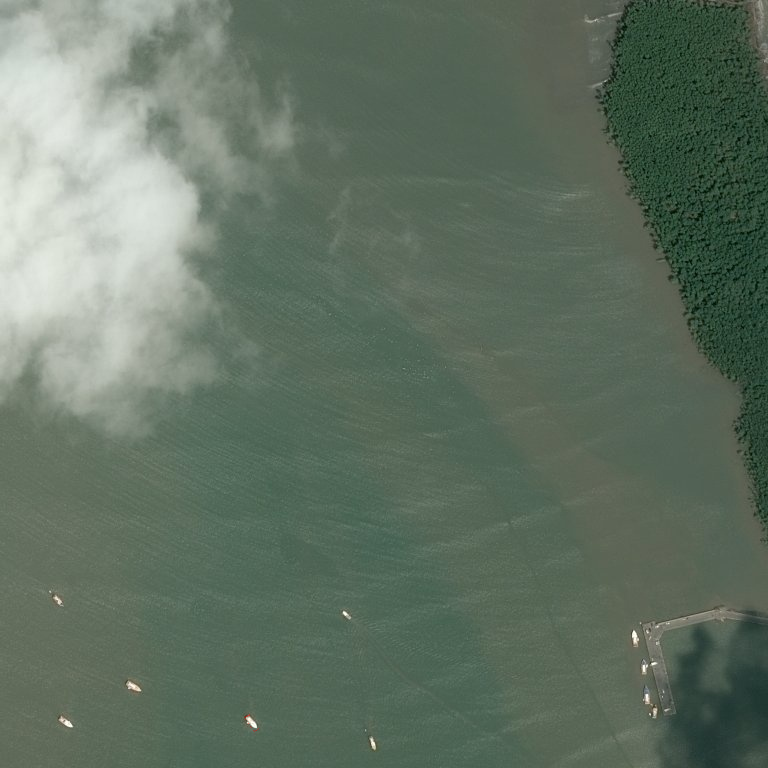


--- Problematic Image 74968 ---
ImageId: eb45bf420
Number of shapes: 2
Shape sizes: [3, 10]


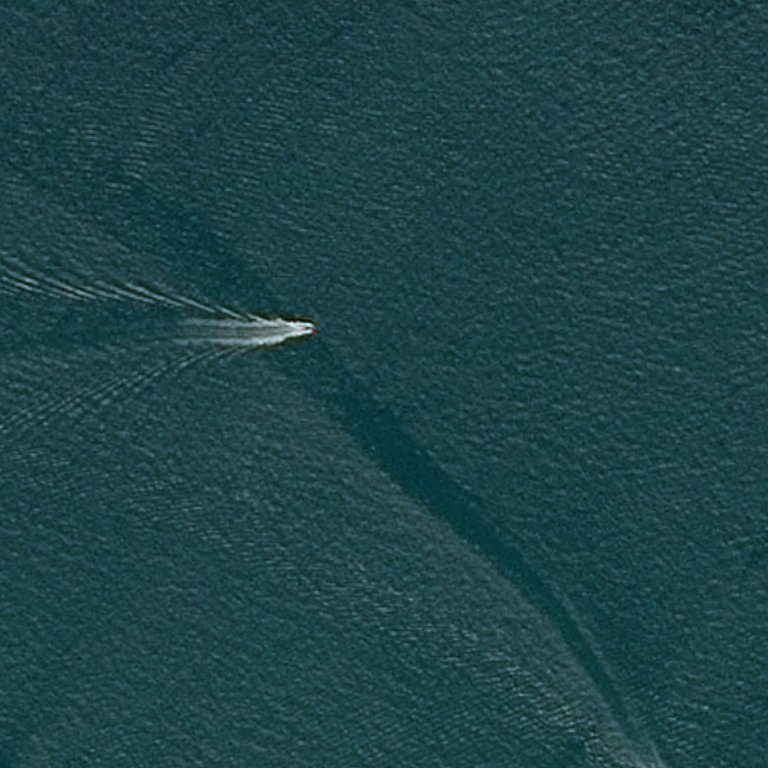


--- Problematic Image 57324 ---
ImageId: b35028340
Number of shapes: 8
Shape sizes: [1, 1, 1, 1, 1, 1, 1, 7]


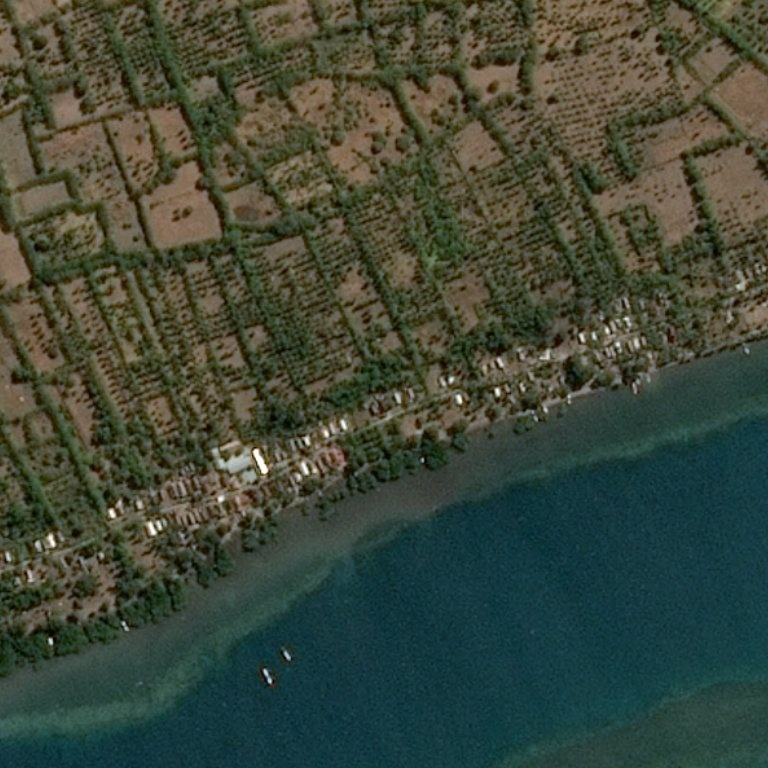

In [52]:
def analyze_problematic_shapes(
    problematic_shapes: pd.DataFrame,
    masks_df: pd.DataFrame,
    n_images: int = 3
):
    """
    Randomly display problematic images (images with more than one shape).

    :param problematic_shapes: DataFrame containing problematic mask information, returned by `analyze_shapes_in_masks()`
    :param masks_df: Original masks DataFrame with columns 'ImageId' and 'EncodedPixels'
    :param n_images: Number of random problematic images to display (default is 3)
    """
    if problematic_shapes.empty:
        print("No problematic images found!")
        return

    n_images = min(n_images, len(problematic_shapes))
    sampled_rows = problematic_shapes.sample(n=n_images)

    for i, row in sampled_rows.iterrows():
        original_index = row["index"]
        mask_row = masks_df.iloc[original_index]
        
        image_id = mask_row.ImageId.split('.')[0]

        mask = get_mask_from_rle(mask_row.EncodedPixels)

        print(f"\n--- Problematic Image {i+1} ---")
        print(f"ImageId: {image_id}")
        print(f"Number of shapes: {row.num_shapes}")
        print(f"Shape sizes: {row.shape_sizes}")

        visualize_image_with_mask(image_id, mask)

analyze_problematic_shapes(problematic_shapes, masks)

##### Validation Criteria
- Masks should not overlap, as two boats cannot occupy the same physical space in the image.

##### Methodology
1. Read in the segmentation CSV file.
2. Convert each RLE mask into a 2D binary mask.
3. Check for overlapping shapes across all masks of the same image.

In [53]:
from utils import rles_to_combined_mask, has_overlap

In [54]:

from constants import SHAPE

def analyze_mask_overlaps(masks_df: pd.DataFrame, shape = SHAPE) -> pd.DataFrame:
    """
    Analyze whether masks for each image overlap.

    :param masks_df: DataFrame containing mask RLEs with columns 'ImageId' and 'EncodedPixels'
    :param shape: Tuple of (height, width) specifying the dimensions of the 2D masks
    :return: DataFrame with columns 'image_id' and 'has_overlap' (True/False)
    """
    grouped = masks_df.groupby("ImageId")
    results = []

    for image_id, group in tqdm(grouped, desc="Analyzing masks"):
        rle_list = group["EncodedPixels"].tolist()

        combined_mask = rles_to_combined_mask(rle_list, shape)
        overlap = has_overlap(combined_mask)

        results.append({
            "image_id": image_id,
            "has_overlap": overlap,
        })

    return pd.DataFrame(results)

In [55]:
masks = load_masks(original = True, filter_empty = True)
overlaps = use_cache(analyze_mask_overlaps)(masks)

total_images = len(overlaps)
num_overlaps = overlaps["has_overlap"].sum()
percent_overlaps = num_overlaps / total_images * 100

print(f"Total images analyzed (with masks): {total_images}")
print(f"Number of images with overlapping masks: {num_overlaps}")
print(f"Percentage of overlapping images: {percent_overlaps:.2f}%\n")

Total images analyzed (with masks): 42556
Number of images with overlapping masks: 0
Percentage of overlapping images: 0.00%



## Data Cleaning

##### Methodology
- Remove masks with no valid shapes: If a mask contains no shapes larger than 12 pixels, discard the mask entirely.  
- Keep only the largest shape: For masks with multiple shapes, remove all shapes except the largest one to ensure each mask corresponds to a single boat.

In [56]:
from utils import keep_largest_shape, get_rle_from_mask

In [57]:
masks = load_masks(original = True)
shapes = use_cache(analyze_shapes_in_masks)(masks)

problematic_images = shapes[
    (shapes["num_shapes"] > 1) |
    (shapes["shape_sizes"].apply(lambda sizes: all(s < MIN_SHAPE_SIZE for s in sizes)))
]

for _, row in problematic_images.iterrows():
    original_index = row["index"]
    mask_row = masks.iloc[original_index]

    mask = get_mask_from_rle(mask_row.EncodedPixels)

    if all(s < MIN_SHAPE_SIZE for s in row.shape_sizes):
        masks.at[original_index, "EncodedPixels"] = ""

    else:
        cleaned_mask = keep_largest_shape(mask)
        new_rle = get_rle_from_mask(cleaned_mask)
        masks.at[original_index, "EncodedPixels"] = new_rle

masks.to_csv("./data/segmentations.csv", index=False)